<a href="https://colab.research.google.com/github/mohitmeht/Research_codes/blob/master/Simulating_voltage_response_in_Li_air.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Plotting polarization curve using Prof. Petru Andrei's equation as discussed in (Mehta, Bevara, and Andrei, “Maximum Theoretical Power Density of Lithium–Air Batteries with Mixed Electrolyte.”) 

## Import libraries

In [0]:
import scipy.constants as sciconst
import numpy as np
import matplotlib.pylab as plt
from numba import jit,njit,vectorize
from scipy.optimize import fsolve


## Compute thermal voltage

In [0]:
@jit(parallel=True,fastmath=True)
def thermalvoltage(T=300):
  kb = (sciconst.physical_constants['Boltzmann constant'])[0]
  eV = (sciconst.physical_constants['electron volt'])[0]
  kb_div_eV = np.divide(kb,eV) 
  ThermalVoltage = np.multiply(T,kb_div_eV)
  return ThermalVoltage

## Compute $\lambda$ from the paper
\begin{equation}
\lambda = \tanh^{-1}\left(\frac{a}{b}\right)
\end{equation}
Diffusion length ($\lambda$) is based on Petru's theory to compute the electrochemical impedance spectra in Li-air/O$_2$ batteries. 
This function return a value, lambda.
$\lambda^2 = \frac{D_\textrm{eff}}{k}$ is in cm.

\begin{equation}
\lambda I_F= nFAD_\textrm{eff}c_{o_2}\tanh\left(\frac{l}{\lambda}\right)
\end{equation} 
or 
\begin{equation}
j_F \lambda= nFD_\textrm{eff}c_{o_2}\tanh\left(\frac{l}{\lambda}\right)
\end{equation}
where, 

$n$ is the number of charge transfer electrons, 

$F_\textrm{const}$ is the Faradaic constant in C/mol,

$A$ is the cross sectional area of the cathode  in cm$^2$ (removed when using current density and not current),

$D\textrm{eff}$ is the effective oxygen diffusion coefficient in the organic electrolyte in cm$^2$/s,

$L_c$ = Length of the cathode in cm,

$j_{dis}$ is the value of the dc discharge current density in A/cm$^2$,

$f$ is the function used to solve the non-linear equation using a numerical receipe to find the diffusion length ($\lambda$),

$c_\textrm{int}$ is the inital concentration of oxygen dissolved in the electrolyte in mol/cm$^3$.

The diffusion length is required to compute the voltage drop due to oxygen concentration polarization.

In [0]:
@jit(parallel=True,fastmath=True,target='cpu')
def f(x,n,F,Deff,c_int,Lc,j_dis):
  Fa_const = n*F*A*Deff*c_int
  tanh_func = np.tanh(np.divide(Lc,x))
  Fa = np.multiply(Fa_const,tanh_func)
  Fb = np.multiply(j_dis,x)
  # print("{}\n{}\n{}\n{}\n{}\n{}\n{}".format(n,F,A,Deff,c_int,l,I_dis))
  return np.subtract(Fa,Fb) #F = (n.*F_const.*A.*Deff.*c_int.*tanh(Lc./x))-(j_dis.*x));

@jit(parallel=True,fastmath=True)
def petru_equation(n,F,A,Deff,c_int,l,jdis):
  x0 = np.multiply(0.1,np.ones_like(jdis))
  lam = fsolve(func=f,x0=x0,args=(n,F,Deff,c_int,l,jdis))
  return lam

## Constants
Here all the constants and variables needed for calculation of discharge voltage are listed.

In [0]:
n = 2;
F_const = (sciconst.physical_constants['Faraday constant'])[0]
A = 1.131; # in cm2
Do2 = 24e-6; # in cm2/s
porol = 0.4;
brugg = 1.5
Deff = np.multiply(Do2,np.power(porol,brugg)); # in cm2/s
c_int = 8.76e-6;# in mol/cm3
l = 0.08#12.0e-4; # in cm, Cathode of 12um
T = 300.; # in K
a = 1.4286e5; # in 1/cm
beta = 0.5;
k0 = 0.0020e-8; # in cm/s
ja0 = 6.17e-4; # in A/cm2
Eeq = 2.959 # in V
jdis_lst = np.arange(0.5,10.1,0.5)*1e-3
Vt = thermalvoltage(T)

## Computing discharge voltage
The open circuit voltage as a result of oxygen polarization is calculated below. This formulation neglects the change in microstructural properties of the cathode such as porosity, tortuosity, and active surface area, and the voltage drop across lithium peroxide. The results from this relationship is the optimistic estimate of the OCV or the plateau voltage.

In [0]:
lam  = petru_equation(n,F_const,A,Deff,c_int,l,jdis_lst)
k = np.divide(Deff,np.power(lam,2.))
eta_c_sinh = -Vt/n/beta*np.arcsinh(k/(2.*k0*a))
eta_a_sinh = -2.*Vt*np.arcsinh(jdis_lst/ja0/2.)
eta_sinh = eta_a_sinh + eta_c_sinh
V = Eeq+eta_sinh

## Plotting the polarization curve

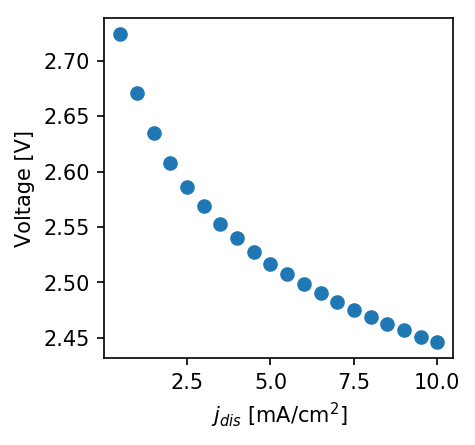

In [114]:
fig1 = plt.figure(num=1,figsize=[3,3],facecolor=None,edgecolor=None,dpi=150)
ax1 = fig1.add_subplot(111)
ax1.set_facecolor('None')
ax1.set_xlabel('$j_{dis}$ [mA/cm$^{2}$]')
ax1.set_ylabel('Voltage [V]')  
ax1.plot(jdis_lst*1.0e3,V,'o',color='tab:blue')
plt.show()